In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# # Import the linear regression model class
from pymer4.models import Lm

# # Import the lmm model class
from pymer4.models import Lmer

# Import Gaussian modeling
import statsmodels.formula.api as smf

import scipy as sp
from scipy import stats


ModuleNotFoundError: No module named 'pymer4'

In [99]:
df_load = pd.read_csv('merged_logs.csv')

In [100]:
df  = df_load.copy()

df = df.drop_duplicates(subset=['_id'])
before = len(df)
mt=0.25
print(f"Before filtering: {before}")
df = df.query("0<timeSpent_message < 60 or variant !='explain'")
df = df.query("0<timeSpent_read < 60 or variant !='reading'")
df = df.query("0<timeSpent_quiz < 60")

quantiles_per_ex = df.groupby("exerciseId")[["timeSpent_message","timeSpent_quiz","timeSpent_read"]].quantile([0.025, 0.975]).reset_index()

for ex in quantiles_per_ex["exerciseId"].unique():
    q1 = quantiles_per_ex.query("exerciseId == @ex and level_1 == 0.025").values[0]
    q3 = quantiles_per_ex.query("exerciseId == @ex and level_1 == 0.975").values[0]
    df = df.query("exerciseId != @ex or (@q1[2]<timeSpent_message < @q3[2] or variant!='explain') and @q1[3]<timeSpent_quiz < @q3[3] and (@q1[4]<timeSpent_read < @q3[4] or variant!='reading')")
after = len(df)

print(f"After filtering: {after}")
print(f"Filtered out: {before - after} ({(before - after) / before * 100:.2f}%)")


Before filtering: 8767
After filtering: 6442
Filtered out: 2325 (26.52%)


In [101]:
from sklearn.preprocessing import StandardScaler
df["timeSpent_quiz_s"] = StandardScaler().fit_transform(df["timeSpent_quiz"].values.reshape(-1, 1))




/var/folders/l5/6hdc9vld0fg61cf6tjrw3f100000gn/T/ipykernel_21736/4191545852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["timeSpent_quiz_s"] = StandardScaler().fit_transform(df["timeSpent_quiz"].values.reshape(-1, 1))


In [102]:
df["week"] = df["week"].str.extract(r"(\d+)").astype(int)

In [103]:
exlist = df["exerciseName"].unique()

In [104]:
df["ex_number"] = df["exerciseName"].apply(lambda x: np.where(exlist == x)[0][0])
df

,_creationTime,_id,variant,userId,exerciseId,exerciseName,week,controlGroup,userGroup,n_attempts,...,gender,section,semester,coding,midterm,final,grade_out_of_100,grade_out_of_6,timeSpent_quiz_s,ex_number
0,2024-03-03 14:37:38.193977051,k573p8yffe640b2hdz52ypmpj96mjp7a,reading,js700ez83nkj5anqr0mm15wwg96mf00y,k17986at882ejjew66z1bgx5w96m67y2,Insertion Sort,1,A,A,3,...,Female,SC,Bachelor semester 6,85.0,50,64,64.6,4.5,1.472120,0
2,2024-03-08 08:21:41.581866699,k57096j5za8xpvtjcycdhn4eyd6mxe58,explain,js700ez83nkj5anqr0mm15wwg96mf00y,k176kbpqj80xdnz0dsrznxx7856mmgy9,Maximum Sum Subarray,2,B,A,4,...,Female,SC,Bachelor semester 6,85.0,50,64,64.6,4.5,-0.519391,1
3,2024-03-08 08:21:50.982680908,k570h8jfwy2mywrxpmkdymgv4n6mw4k8,reading,js700ez83nkj5anqr0mm15wwg96mf00y,k172pq4w6s747qpvz0aebwz50n6mnvgg,Strassen’s Algorithm,2,A,A,6,...,Female,SC,Bachelor semester 6,85.0,50,64,64.6,4.5,-0.116263,2
5,2024-03-14 15:49:12.777255127,k571bv9c28tepf7qggfev6fna16n91sm,explain,js700ez83nkj5anqr0mm15wwg96mf00y,k173an7ns7g76j493paexdh88d6n3bsh,Priority Queues,3,B,A,3,...,Female,SC,Bachelor semester 6,85.0,50,64,64.6,4.5,-0.508431,3
6,2024-04-01 14:29:35.625932373,k57537fzc349hcdzk4j3cmmdrx6pcm5s,reading,js700ez83nkj5anqr0mm15wwg96mf00y,k17asvnfeyp3q949hdkwjq2and6p2x6e,Matrix-Chain Multiplication,4,A,A,1,...,Female,SC,Bachelor semester 6,85.0,50,64,64.6,4.5,-0.891639,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8762,2024-05-13 23:11:41.818883545,k570d8g4jfw8kyysjad05ejf2n6s1948,explain,js7fzrkvsmssq18sm3j0pnsgcs6ms3hm,k179wpzex0za69rx2wyv02e9hd6rj4fb,Kruskal's algorithm,9,A,B,1,...,Male,IN,Bachelor semester 4,100.0,60,73,73.6,5.0,-0.925202,20
8763,2024-05-20 22:06:10.583631348,k5710wfx379y3mv4a2xmyqvcqx6secbb,explain,js7fzrkvsmssq18sm3j0pnsgcs6ms3hm,k176kkt806khrpxnctb9hczm316rtsrq,Dijkstra,10,A,B,1,...,Male,IN,Bachelor semester 4,100.0,60,73,73.6,5.0,-0.751358,10
8764,2024-05-20 22:09:38.864160156,k575gnmzeggtwzhjd6kycw3eh56set5n,reading,js7fzrkvsmssq18sm3j0pnsgcs6ms3hm,k177dxhnpwwtrq9dy5770jmrwx6rvzrr,Bellman-Ford,10,B,B,1,...,Male,IN,Bachelor semester 4,100.0,60,73,73.6,5.0,-0.769828,11
8765,2024-05-28 08:09:14.397613037,k572tzxcbe8y4y8eezewr5dk5h6sz53f,reading,js7fzrkvsmssq18sm3j0pnsgcs6ms3hm,k17416m11n2qpqy5sr2zz6782s6s2y2n,Quicksort,11,B,B,2,...,Male,IN,Bachelor semester 4,100.0,60,73,73.6,5.0,-0.724864,12


In [105]:
df.columns

Index(['_creationTime', '_id', 'variant', 'userId', 'exerciseId',
       'exerciseName', 'week', 'controlGroup', 'userGroup', 'n_attempts',
       'timeSpent_quiz', 'n_mess', 'timeSpent_message', 'timeSpent_read',
       'gender', 'section', 'semester', 'coding', 'midterm', 'final',
       'grade_out_of_100', 'grade_out_of_6', 'timeSpent_quiz_s', 'ex_number'],
      dtype='object')

In [106]:
df["variant"] = (df["variant"]=="explain").astype(int)

In [107]:
df["timeSpent_activity"] = df[["timeSpent_read","timeSpent_message","variant"]].apply(lambda x : x[0] if x[2] == 0 else x[1], axis=1)


/var/folders/l5/6hdc9vld0fg61cf6tjrw3f100000gn/T/ipykernel_21736/2505485887.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["timeSpent_activity"] = df[["timeSpent_read","timeSpent_message","variant"]].apply(lambda x : x[0] if x[2] == 0 else x[1], axis=1)


In [109]:
df_ana = df[["ex_number","variant","timeSpent_activity","week","n_attempts","userId",'coding', 'midterm', 'final',
       'grade_out_of_100', 'grade_out_of_6',"timeSpent_quiz","timeSpent_quiz_s"]]


In [110]:
df_ana["userId"] = df_ana["userId"].astype("category")
df_ana["userId"] = df_ana["userId"].cat.codes

/var/folders/l5/6hdc9vld0fg61cf6tjrw3f100000gn/T/ipykernel_21736/2733174401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ana["userId"] = df_ana["userId"].astype("category")
/var/folders/l5/6hdc9vld0fg61cf6tjrw3f100000gn/T/ipykernel_21736/2733174401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ana["userId"] = df_ana["userId"].cat.codes


In [111]:
df_ana

,ex_number,variant,timeSpent_activity,week,n_attempts,userId,coding,midterm,final,grade_out_of_100,grade_out_of_6,timeSpent_quiz,timeSpent_quiz_s
0,0,0,0.083347,1,3,0,85.0,50,64,64.6,4.5,19.594639,1.472120
2,1,1,9.077760,2,4,0,85.0,50,64,64.6,4.5,3.605500,-0.519391
3,2,0,1.865586,2,6,0,85.0,50,64,64.6,4.5,6.842076,-0.116263
5,3,1,11.459317,3,3,0,85.0,50,64,64.6,4.5,3.693498,-0.508431
6,4,0,25.666401,4,1,0,85.0,50,64,64.6,4.5,0.616853,-0.891639
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8762,20,1,5.730746,9,1,451,100.0,60,73,73.6,5.0,0.347389,-0.925202
8763,10,1,13.454895,10,1,451,100.0,60,73,73.6,5.0,1.743123,-0.751358
8764,11,0,17.192692,10,1,451,100.0,60,73,73.6,5.0,1.594831,-0.769828
8765,12,0,0.178798,11,2,451,100.0,60,73,73.6,5.0,1.955833,-0.724864


<Axes: ylabel='Frequency'>

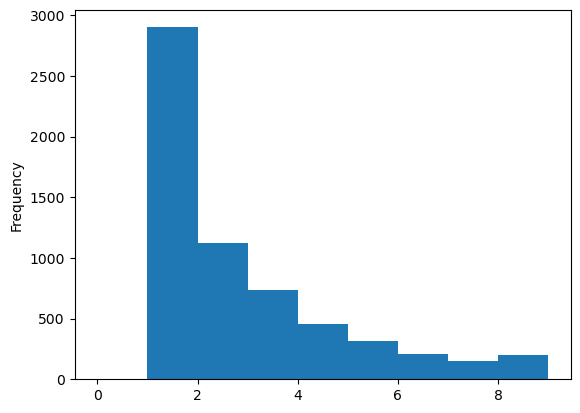

In [112]:
df_ana.n_attempts.plot(kind='hist',bins=np.arange(0,10,1))

In [113]:
df_ana.query("week==4")["n_attempts"].sum()

np.int64(1590)

In [114]:
# convert all entries to float
df_ana = df_ana.astype(float)
df_ana.to_csv("numerical.csv",index=False)

In [115]:
df = df_ana.copy()

In [1]:
models_str_3 = "timeSpent_quiz ~ 1 + variant + (1|userId) + ex_number"
model3 = Lmer(models_str_3, data=df, family="gaussian")
results3 = model3.fit()
display(results3)

NameError: name 'Lmer' is not defined

In [117]:
models_str_3 = "timeSpent_quiz_s ~ 1 + variant + (1|userId) + (1|ex_number)"
model3 = Lmer(models_str_3, data=df, family="gaussian")
results3 = model3.fit()
display(results3)

Linear mixed model fit by REML [’lmerMod’]
Formula: timeSpent_quiz_s~1+variant+(1|userId)+(1|ex_number)

Family: gaussian	 Inference: parametric

Number of observations: 6442	 Groups: {'userId': 452.0, 'ex_number': 22.0}

Log-likelihood: -8400.340 	 AIC: 16810.680

Random effects:

                  Name    Var    Std
userId     (Intercept)  0.067  0.259
ex_number  (Intercept)  0.219  0.468
Residual                0.739  0.860

No random effect correlations specified

Fixed effects:



/Users/amaurygeorge/anaconda3/envs/ml4ed/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.073,-0.127,0.272,0.102,22.087,0.713,0.483,
variant,-0.083,-0.125,-0.041,0.022,6052.430,-3.842,0.000,***


In [90]:
# Train model on classifying the variant (machine learning)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

df["variant"] = df["variant"].astype(int)
X = df[["ex_number","timeSpent_quiz","userId"]]
y = df["variant"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
display(X_train)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(y_pred)
print(classification_report(y_test, y_pred))

,ex_number,timeSpent_quiz,userId
6146,20.0,0.710206,317.0
1639,20.0,4.319113,81.0
2773,0.0,6.905267,141.0
871,2.0,28.879325,43.0
8712,4.0,3.443116,449.0
...,...,...,...
5159,2.0,8.200904,265.0
7113,7.0,44.015979,367.0
7156,4.0,2.717240,370.0
7412,11.0,25.841364,383.0


[1 1 1 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.48      0.53      0.50      1073
           1       0.47      0.43      0.45      1053

    accuracy                           0.48      2126
   macro avg       0.48      0.48      0.48      2126
weighted avg       0.48      0.48      0.48      2126



In [91]:
models_str_3 = "timeSpent_quiz ~ 0+ variant + (1|userId) + (1|ex_number)"
model3 = Lmer(models_str_3, data=df, family="gaussian")
results3 = model3.fit()
display(results3)
display(model3.ranef[1])


Linear mixed model fit by REML [’lmerMod’]
Formula: timeSpent_quiz~0+variant+(1|userId)+(1|ex_number)

Family: gaussian	 Inference: parametric

Number of observations: 6442	 Groups: {'userId': 452.0, 'ex_number': 22.0}

Log-likelihood: -21835.548 	 AIC: 43679.096

Random effects:

                  Name     Var    Std
userId     (Intercept)   4.308  2.076
ex_number  (Intercept)  82.770  9.098
Residual                47.623  6.901

No random effect correlations specified

Fixed effects:



/Users/amaurygeorge/anaconda3/envs/ml4ed/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
variant,-0.634,-0.973,-0.296,0.173,6069.264,-3.67,0.0,***


,X.Intercept.
0,5.624075
1,8.801784
2,8.170434
3,8.815491
4,3.864269
5,8.523301
6,12.572151
7,18.065316
8,7.516119
9,5.351807


In [92]:
whole_reg = "timeSpent_quiz ~ 1 + variant + (1|userId) + (1|ex_number) + n_attempts + coding + midterm + final + grade_out_of_100 + grade_out_of_6"
model = Lmer(whole_reg, data=df, family="gaussian")
results = model.fit()
display(results)


Linear mixed model fit by REML [’lmerMod’]
Formula: timeSpent_quiz~1+variant+(1|userId)+(1|ex_number)+n_attempts+coding+midterm+final+grade_out_of_100+grade_out_of_6

Family: gaussian	 Inference: parametric

Number of observations: 6442	 Groups: {'userId': 452.0, 'ex_number': 22.0}

Log-likelihood: -20602.270 	 AIC: 41226.540

Random effects:

                  Name     Var    Std
userId     (Intercept)   3.933  1.983
ex_number  (Intercept)   7.804  2.794
Residual                32.166  5.672

No random effect correlations specified

Fixed effects:



/Users/amaurygeorge/anaconda3/envs/ml4ed/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),7.987,3.470,12.504,2.305,449.225,3.465,0.001,***
variant,-0.618,-0.897,-0.340,0.142,6039.728,-4.346,0.000,***
n_attempts,1.139,1.098,1.180,0.021,6405.549,54.257,0.000,***
coding,-0.005,-0.015,0.005,0.005,520.444,-0.933,0.351,
midterm,-0.008,-0.032,0.017,0.012,576.616,-0.617,0.537,
final,-0.030,-0.090,0.030,0.031,521.207,-0.991,0.322,
grade_out_of_100,0.073,-0.098,0.243,0.087,447.220,0.835,0.404,
grade_out_of_6,-1.155,-4.186,1.876,1.546,418.431,-0.747,0.455,


In [93]:
models_str_3 = "grade_out_of_100 ~ 1 + timeSpent_quiz + (1|ex_number)"
model3 = Lmer(models_str_3, data=df, family="gaussian")
results3 = model3.fit()
display(results3)
display(model3.ranef)

Linear mixed model fit by REML [’lmerMod’]
Formula: grade_out_of_100~1+timeSpent_quiz+(1|ex_number)

Family: gaussian	 Inference: parametric

Number of observations: 6442	 Groups: {'ex_number': 22.0}

Log-likelihood: -26278.433 	 AIC: 52564.865

Random effects:

                  Name      Var     Std
ex_number  (Intercept)    2.186   1.479
Residual                203.395  14.262

No random effect correlations specified

Fixed effects:



/Users/amaurygeorge/anaconda3/envs/ml4ed/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),73.583,72.782,74.384,0.409,29.838,179.982,0.0,***
timeSpent_quiz,-0.224,-0.271,-0.177,0.024,3235.604,-9.358,0.0,***


,X.Intercept.
0,-1.797225
1,-0.867015
2,-1.141143
3,-0.781662
4,-0.496093
5,0.387251
6,0.350379
7,3.390310
8,0.502904
9,-0.445458
